In [65]:
import networkx as nx
from networkx.algorithms import community
import numpy as np
import matplotlib.pyplot as plt 
import random
import pandas as pd
from collections import Counter
import statistics
import itertools
from simulation import Simulation
import string

# Sample Graph

In [90]:
df=pd.read_csv('youtube.txt',sep='\t')
ALL=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())
nx.info(ALL)

'Graph with 1134890 nodes and 2987624 edges'

Graph with 24425 nodes and 30000 edges


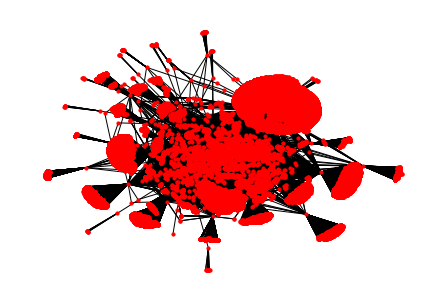

In [80]:
df=pd.read_csv('youtube.txt',sep='\t',nrows=30000)
G=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())
print(nx.info(G))
nx.draw(G,node_size=10,node_color="red")

# Degree Distribution

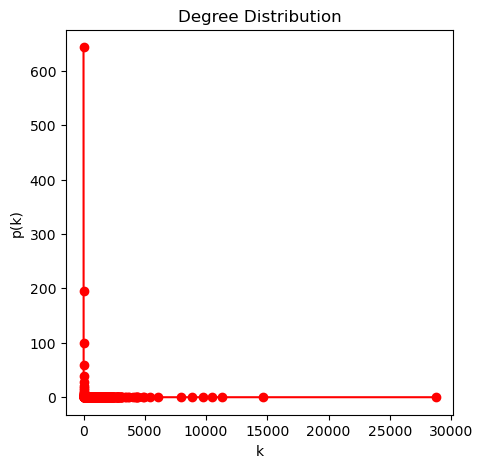

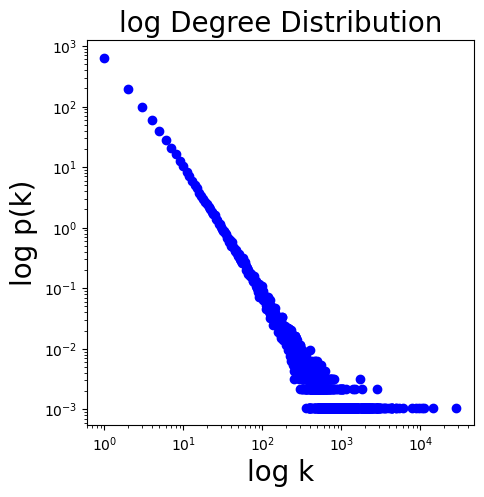

In [92]:
def plot_degree_dist(ALL):
   
    degrees = ALL.degree()
    degrees = dict(degrees)
    values = sorted(set(degrees.values()))
    histo = [list(degrees.values()).count(x) for x in values]
    P_k = [x / G.order() for x in histo]
    
    plt.figure()
    plt.plot(values, P_k, "ro-")
    plt.xlabel("k")
    plt.ylabel("p(k)")
    plt.title("Degree Distribution")
    plt.show()
    
    plt.figure()
    plt.grid(False)
    plt.loglog(values, P_k, "bo")
    plt.xlabel("log k", fontsize=20)
    plt.ylabel("log p(k)", fontsize=20)
    plt.title("log Degree Distribution", fontsize=20)
    plt.show()

plt.rcParams.update({'figure.figsize': (5, 5)})
plot_degree_dist(ALL)

# Random Failure

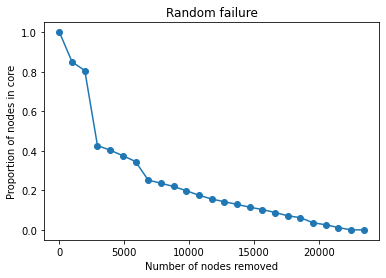

In [15]:
C = G.copy()
nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
num_nodes_removed = range(0, G.number_of_nodes(), M)
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)
    
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')

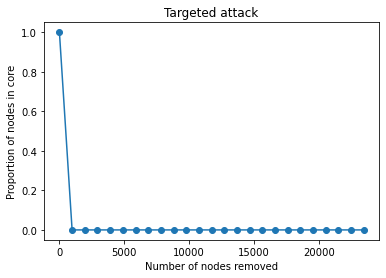

In [16]:
##Targeted Attack##
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]

N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)
        
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')

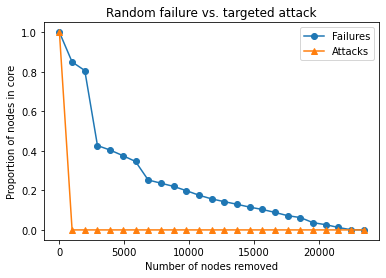

In [17]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()

# Modularity

C:\Users\ahmed\AppData\Local\Temp/ipykernel_12428/2268984523.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(Y.nodes, 300)


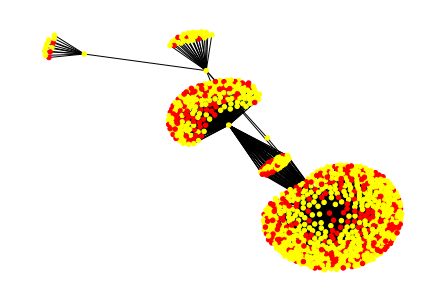

In [41]:
df=pd.read_csv('youtube.txt',sep='\t',nrows=1000)
Y=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())

random_nodes = random.sample(Y.nodes, 300)
random_partition = [set(random_nodes),
                    set(Y.nodes) - set(random_nodes)]

random_node_colors = ['red' if n in random_nodes else 'yellow' for n in Y.nodes]
nx.draw(Y, node_color=random_node_colors,node_size=20)

In [42]:
nx.community.quality.modularity(Y, random_partition)

-0.08942049999999996

# Girvan-Newman clustering

In [49]:
G=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())
partition_sequence = []
for _ in range(G.number_of_edges()):
    my_edge_betweenness = nx.edge_betweenness_centrality(G)
    most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
    G.remove_edge(*most_valuable_edge)
    my_partition = list(nx.connected_components(G))
    partition_sequence.append(my_partition)

In [50]:
len(partition_sequence), nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph()).number_of_edges()

(1000, 1000)

In [51]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W


In [52]:
G=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())
modularity_sequence = [modularity(G, p) for p in partition_sequence]

Text(0.5, 0, 'Algorithm step')

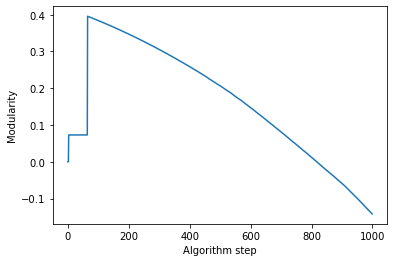

In [53]:
plt.plot(modularity_sequence)
plt.ylabel('Modularity')
plt.xlabel('Algorithm step')

### partition with highest modularity

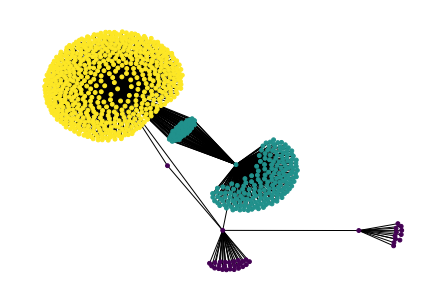

In [54]:
def my_modularity(partition):
    return nx.community.quality.modularity(G, partition)
best_partition = max(partition_sequence, key=my_modularity)

def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

best_partition_map = create_partition_map(best_partition)

node_colors = [best_partition_map[n] for n in G.nodes()]
nx.draw(G, node_color=node_colors,node_size=15)

In [55]:
nx.community.quality.modularity(G, best_partition)

0.39569350000000003

### the best partition with a given number of communities

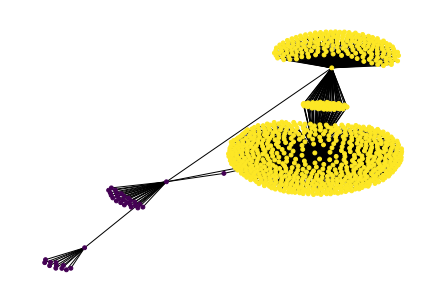

In [56]:
for partition in partition_sequence:
    if len(partition) == 2:
        two_cluster_partition = partition
        break


two_cluster_partition_map = create_partition_map(two_cluster_partition)

node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, node_color=node_colors,node_size=15)

In [57]:
nx.community.quality.modularity(G, two_cluster_partition)

0.07287949999999999

## Louvain’s Algorithm for Community Detection

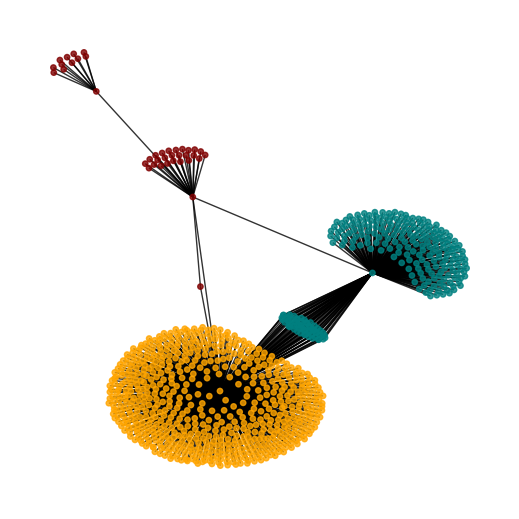

In [95]:
# pip install community
# pip install python-louvain
from community import community_louvain
df=pd.read_csv('youtube.txt',sep='\t',nrows=1000)
G=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())
comms = community_louvain.best_partition(G)
unique_coms = np.unique(list(comms.values()))
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'orange', 
    
}

node_cmap = [cmap[v] for _,v in comms.items()]

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 15, alpha = 0.8, node_color=node_cmap)
plt.show()

# Simulation

In [60]:
S=nx.from_pandas_edgelist(df,"FromNodeId","ToNodeId",create_using=nx.Graph())

def initial_state(S):
    state = {}
    for node in S.nodes:
        state[node] = 'asleep'
    return state

P_AWAKEN = 0.2
def state_transition(S, current_state):
    next_state = {}
    for node in S.nodes:
        if current_state[node] == 'asleep':
            if random.random() < P_AWAKEN:
                next_state[node] = 'awake'
    return next_state

test_state = initial_state(S)
state_transition(S, test_state)

sim = Simulation(S, initial_state, state_transition, name='Simple Sim')

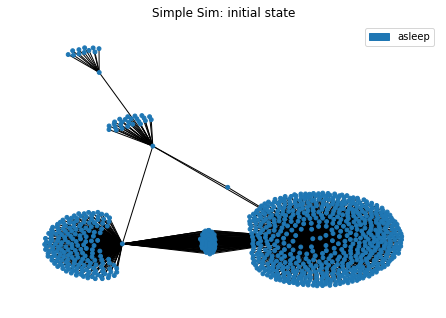

In [61]:
sim.draw(node_size=15)

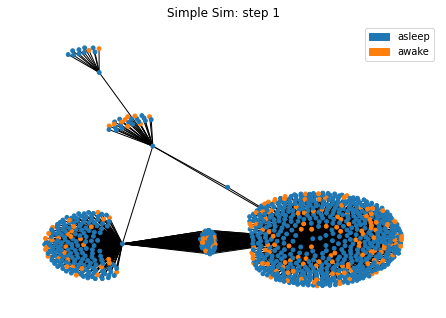

In [62]:
sim.run()
sim.draw(node_size=15)

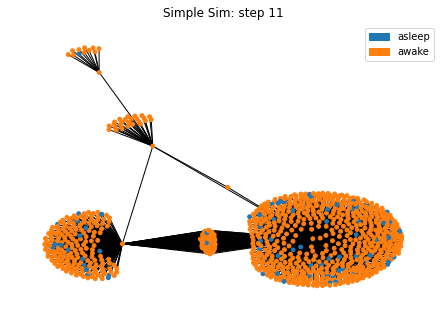

In [63]:
sim.run(10)
sim.draw(node_size=15)

<AxesSubplot:title={'center':'Simple Sim: node state proportions'}, xlabel='Simulation step', ylabel='Proportion of nodes'>

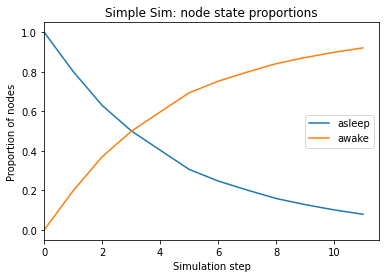

In [64]:
sim.plot()

# Centrality distributions

In [81]:
nx.info(G)

'Graph with 24425 nodes and 30000 edges'

In [82]:
degree_sequence = [G.degree(n) for n in G.nodes]
degree_counts = Counter(degree_sequence)

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean degree: 2.4564994882292734
Median degree: 1
Mean betweenness: 9.007107929672501e-05
Median betweenness: 0.0
